<a href="https://colab.research.google.com/github/topchaebol/006762/blob/master/4_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0_%EA%B8%B0%EB%B3%B8_%EA%B0%9C%EB%85%90_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 간단하게 그래프 만들고 실행하기

In [0]:
import tensorflow as tf

# 그래프 생성
matrix1 = tf.constant([[3., 3.]])
matrix2 = tf.constant([[2.],[2.]])
product = tf.matmul(matrix1, matrix2)

# 그래프 실행
sess = tf.Session()
result = sess.run(product)
sess.close()

print(result)

[[12.]]


# 2 텐서플로우의 상수, 변수, 플레이스홀더

In [0]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)
output = input1 * input2

with tf.Session() as sess:
  print(sess.run(output, feed_dict={
                                   input1:[7.],
                                   input2:[2.]}))

[14.]


# 3 텐서플로우를 활용한 단층망 만들기

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [0]:
import tensorflow as tf

# 네트워크에 필요한 변수
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# 네트워크 생성
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

# 코스트 구하기
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# 최적화 알고리즘
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [0]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  
  for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
  # 모델 평가(몇 개가 맞았는지 확인)
  correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


0.9164


# 4 텐서플로우로 멀티레이어 구현하기
다음 모델을 만족하는 네트워크를 구성하시오
- mnist 데이터셋을 사용하여 목표 정확률 : 96%
- 입력부터 출력, 히든 레이어의 개수: 784 392 196 98 10(각 계층에 RELU 적용)
- GPU를 사용하여 학습
- 입력 레이어부터 히든 레이어, 출력 레이어까지 784, 392, 196, 98, 10의 계층 사용
- epoch: 3000
- batch size: 16
- 100번의 epoch마다 정확률 출력
- Adam 옵티마이저를 사용
- learning rate: 0.001
- 시간에 따른 테스트셋의 정확률과 트레이닝 셋의 정확률을 각각 기록하고 그래프로 시각화

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import tensorflow as tf

# 네트워크 그래프에 필요한 변수 선언
x = tf.placeholder(tf.float32, [None, 784]) # 입력에 필요한 데이터를 넣을 플레이스 홀더
W1 = tf.get_variable("W1", shape=[784, 392], 
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.zeros([392])) # 연산에 필요한 편향치
W2 = tf.get_variable("W2", shape=[392, 196], 
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.zeros([196])) # 연산에 필요한 편향치
W3 = tf.get_variable("W3", shape=[196, 98], 
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.zeros([98])) # 연산에 필요한 편향치
W4 = tf.get_variable("W4", shape=[98, 10], 
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.zeros([10])) # 연산에 필요한 편향치

# 네트워크 생성
l1 = tf.nn.relu(tf.matmul(x, W1) + b1)
l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)
l3 = tf.nn.relu(tf.matmul(l2, W3) + b3)
y = tf.nn.softmax(tf.matmul(l3, W4) + b4)
y_ = tf.placeholder(tf.float32, [None, 10])

# 코스트 구하기
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# 최적화 알고리즘
#train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)


correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

with tf.device('/device:GPU:0'):

  with tf.Session() as sess:
    sess.run(init)
    
    train_ce = dict()
    test_ce = dict()
    train_acc = dict()
    test_acc = dict()
    count = 0

    for i in range(3000):
      batch_xs, batch_ys = mnist.train.next_batch(16)
      sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
      
      if(i%100==99):
        count += 1
        train_ce[count] = sess.run(cross_entropy, 
                                            feed_dict={x: mnist.train.images, y_: mnist.train.labels})
        test_ce[count] = sess.run(cross_entropy, 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        train_acc[count] = sess.run(accuracy, 
                                             feed_dict={x: mnist.train.images, y_: mnist.train.labels})
        test_acc[count] = sess.run(accuracy, 
                                            feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
    # 모델 평가(몇 개가 맞았는지 확인)
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


W0705 01:41:28.243823 140462286874496 deprecation.py:323] From <ipython-input-1-b4ed1d7b95f3>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0705 01:41:28.245266 140462286874496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0705 01:41:28.246193 140462286874496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0705 01:41:28.487266 140462286874496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0705 01:41:28.489416 140462286874496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0705 01:41:28.537156 140462286874496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be remove

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.9489


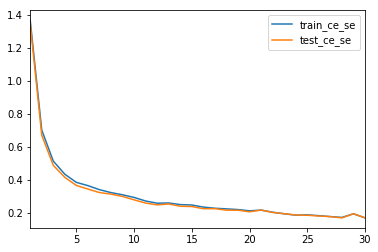

In [0]:
import pandas as pd

train_ce_se = pd.Series(train_ce)
test_ce_se = pd.Series(test_ce)
df = pd.DataFrame([train_ce_se, test_ce_se],
                 index=['train_ce_se', 'test_ce_se']).T
df.plot()


In [0]:
LOG_DIR = 'drive/data/tb_logs'
	
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
	
import os
if not os.path.exists(LOG_DIR):
  os.makedirs(LOG_DIR)
	
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
	
get_ipython().system_raw('./ngrok http 6006 &')
	
!curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-07-05 00:31:07--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.201.75.180, 52.45.111.123, 52.207.111.186, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.201.75.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17556757 (17M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  16.74M  20.7MB/s    in 0.8s    

2019-07-05 00:31:13 (20.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [17556757/17556757]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://b7df7b7f.ngrok.io


In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import TensorBoard
import tensorflow as tf

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf_device = tf.device('/device:GPU:0')

batch_size = 128
num_classes = 10
epochs = 12
	
### input image dimensions
img_rows, img_cols = 28, 28
	
### the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
	
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
	
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
	
### convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
	
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
	
	
tbCallBack = TensorBoard(log_dir=LOG_DIR, 
                           histogram_freq=1,
                           write_graph=True,
                           write_grads=True,
                           batch_size=batch_size,
                           write_images=True)
	
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[tbCallBack])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


W0705 00:31:19.705982 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 00:31:19.707855 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 00:31:19.718993 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 00:31:19.755138 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0705 00:31:19.760015 140167498225536 deprecation_wrapp

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


W0705 00:31:22.042778 140167498225536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples


W0705 00:31:25.408417 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:796: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0705 00:31:25.606624 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:840: The name tf.summary.image is deprecated. Please use tf.compat.v1.summary.image instead.

W0705 00:31:26.825769 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0705 00:31:26.828674 140167498225536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/12
60000/60000 [==============================] - 8s 139us/step - loss: 0.2709 - acc: 0.9165 - val_loss: 0.0587 - val_acc: 0.9806
Epoch 2/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0899 - acc: 0.9741 - val_loss: 0.0412 - val_acc: 0.9861
Epoch 3/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0657 - acc: 0.9805 - val_loss: 0.0339 - val_acc: 0.9885
Epoch 4/12
60000/60000 [==============================] - 5s 77us/step - loss: 0.0548 - acc: 0.9839 - val_loss: 0.0297 - val_acc: 0.9901
Epoch 5/12
60000/60000 [==============================] - 5s 77us/step - loss: 0.0455 - acc: 0.9862 - val_loss: 0.0296 - val_acc: 0.9904
Epoch 6/12
60000/60000 [==============================] - 5s 77us/step - loss: 0.0417 - acc: 0.9878 - val_loss: 0.0270 - val_acc: 0.9915
Epoch 7/12
60000/60000 [==============================] - 5s 77us/step - loss: 0.0379 - acc: 0.9885 - val_loss: 0.0263 - val_acc: 0.9914
Epoch 8/12
60000/60000 [================